### RQ2: Given different kinds of harmful ads identified via RQ1, are there disparities in who gets exposed to them?

e.g. for ads disliked for mistrust-related reasons, do some users see more of them? It would be important here to not throw away the more boring categories like healthcare and opportunity (Elissa suggested)

In [14]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import Counter

from scipy.stats import pearsonr, normaltest
from scipy.stats import kurtosis, skew, mode

plt.rcParams['font.family'] = 'serif'
plt.rcParams["font.serif"] = ["Nimbus Roman"]

#### Question
How does the distribution of potentially harmful ads vary from neutral ads? Limit this question to just our active participants.

! Factor **frequency** into every analysis !

In [15]:
DATA_DIR = '../data/'
active_pids = open(os.path.join(DATA_DIR, 'pid_active_contribs_cleaned.txt'), 'r').readlines()
active_pids = [p.strip() for p in active_pids]
print(len(active_pids))

133


In [16]:
# load PID to ADID mapping of annotated ads
pid_adid_files = [os.path.join(DATA_DIR, f'surveys/survey-{n}/survey{n}_coding_subsample.tsv') for n in range(1, 8)]
pid_adid_files.append(os.path.join(DATA_DIR, 'surveys/survey-1/survey1_batch2_coding_subsample.tsv'))

pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)

# only keep PID ADID mapping for active participants
pid_adid = pid_adid[pid_adid['pid'].isin(active_pids)]
print('pid_adid shape:', pid_adid.shape)  

pid_adid shape: (35387, 2)


In [17]:
codes = pd.read_csv(os.path.join(DATA_DIR, 'ad_codes_transformed.tsv'), sep='\t')
print('codes shape:', codes.shape)

adid_codes = dict(zip(codes['adid'], codes['codes']))

codes shape: (29207, 2)


In [18]:
pid_adid_freqs_noind = pd.read_csv(os.path.join(DATA_DIR, 'participant_ad_freqs.tsv'), sep='\t')
pid_adid_freqs = pid_adid_freqs_noind.set_index(['pid', 'adid'])

In [19]:
DONT_COUNT = ["Can't determine, return to this one", "Study", "UNCAT", 
             "Political", "CA Lawsuit"]

# NOTE: to count for groups of codes, add another parameters
def measure_exposure(pids: list, adid_codes: dict,
                     pid_adid: pd.DataFrame, freqs: pd.DataFrame, code_groups: dict = None) -> dict:
    # map from PID -> Code -> count (frequency included)
    exposure = {p: Counter() for p in pids}
    total_ads = {}    # map from PID to total number of ads
    for p in pids:
        pid_ads = pid_adid[pid_adid['pid'] == p]
        total_ads[p] = 0
        for aid in pid_ads['adid']:            
            f = int(freqs.loc[p, str(aid)])
            if int(aid) in adid_codes:
                allcodes = adid_codes[int(aid)].split(';')                
                if not code_groups:
                    for c in allcodes:
                        if c not in DONT_COUNT:
                            # code c was seen f times by participant p
                            exposure[p][c] += f                
                            total_ads[p] += f
                else:
                    # grouped code counting from `code_groups` in the else clause, don't double-count
                    done = set([])
                    for c in allcodes:
                        if c in code_groups and c not in DONT_COUNT:
                            mapped = code_groups[c]
                            if mapped not in done:
                                # code group mapped was see f times by participant p
                                exposure[p][mapped] += f
                                total_ads[p] += f
                                done.add(mapped)
            else:
                # we don't have annotations for this, don't count in analysis
                # total_ads[p] -= 1
                continue                        
            
    # NOTE: total_ads contains not just number of ads, but number of observations, factoring in frequencies
    return exposure, total_ads

# It was found that 250/36257 ads in pid_adid were not coded in adid_codes

In [20]:
# count exposure and total ads
exposure, ann_ads_count = measure_exposure(active_pids, adid_codes, pid_adid, pid_adid_freqs)

# count grouped exposure
harmful, non_harmful = 'harmful', 'non_harmful'
groups = {
    'Potentially Harmful': harmful, 'Sensitive': harmful, 'Financial': harmful,
    'Clickbait': harmful, 'Potentially Prohibited': harmful, 'Benign': non_harmful,
    'Opportunity': 'other', 'Healthcare': 'other'
}
grouped_exposure, _ = measure_exposure(active_pids, adid_codes, pid_adid, pid_adid_freqs, groups)

**Preliminary Check:** How many ads do these participants have? Can I trust measures of distributions?

Text(0, 0.5, 'frequency')

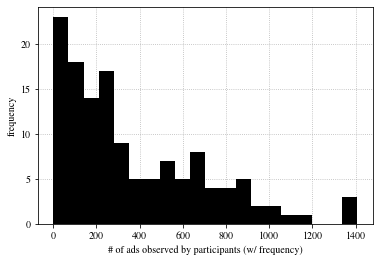

In [10]:
plt.hist(list(ann_ads_count.values()), bins=20, color='k', zorder=10)
plt.grid(ls=':')
plt.xlabel('# of ads observed by participants (w/ frequency)')
plt.ylabel('frequency')

### CDF of problematic vs. benign ads

Neutral: x-axis @ 80%: 60
Healthcare: x-axis @ 80%: 47
Opportunity: x-axis @ 80%: 48
Sensitive: x-axis @ 80%: 45
Financial: x-axis @ 80%: 42
Clickbait: x-axis @ 80%: 39
Potentially Prohibited: x-axis @ 80%: 38
Potentially Harmful: x-axis @ 80%: 36


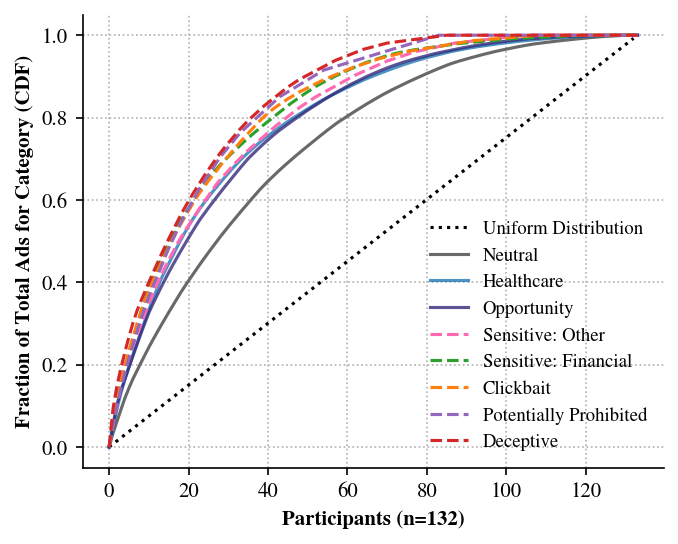

In [150]:
f, ax = plt.subplots()
labels = {'Potentially Harmful': 'Deceptive', 'Financial': 'Sensitive: Financial', 'Sensitive': 'Sensitive: Other'}
colors = {'Financial': 'tab:green', 'Problematic (all together)': 'maroon', 'Problematic': 'maroon',          
          'Benign': 'dimgray', 'Potentially Harmful': 'tab:red', 
          'Clickbait': 'tab:orange', 'Potentially Prohibited': 
          'tab:purple', 'Sensitive': 'hotpink',
          'Healthcare': 'tab:blue', 'Opportunity': '#33297a'}    # copied from Piotr

harmful_counts = [grouped_exposure[p][harmful] for p in active_pids]
harmful_pdf = np.array(harmful_counts) / sum(harmful_counts)
harmful_cdf = [0]
harmful_cdf.extend(np.cumsum(sorted(harmful_pdf, reverse=True)))


neutral_counts = [grouped_exposure[p][non_harmful] for p in active_pids]
neutral_pdf = np.array(neutral_counts) / sum(neutral_counts)
neutral_cdf = [0]
neutral_cdf.extend(np.cumsum(sorted(neutral_pdf, reverse=True)))

# healthcare + opportunity = other 
other_counts = [grouped_exposure[p]['other'] for p in active_pids]
other_pdf = np.array(other_counts) / sum(other_counts)
other_cdf = [0]
other_cdf.extend(np.cumsum(sorted(other_pdf, reverse=True)))

ax.plot(np.arange(len(active_pids)), np.arange(0, 1, 1/len(active_pids)), 'k:', label='Uniform Distribution')
# ax.plot(harmful_cdf, color=colors['Problematic (all together)'], label='Problematic', lw=1.5)
ax.plot(neutral_cdf, color=colors['Benign'], label='Neutral', lw=1.5)
print('Neutral: x-axis @ 80%:', np.where(np.array(neutral_cdf) >= 0.8)[0][0])
# ax.plot(other_cdf, color='goldenrod', label='Somewhat Problematic', lw=1.5)

# solid lines for healthcare and opportunity
for c in ['Healthcare', 'Opportunity']:
    counts = [exposure[p][c] for p in active_pids]
    pdf = np.array(counts) / sum(counts)
    cdf = [0]    # 0 participants = 0 ads
    cdf.extend(np.cumsum(sorted(pdf, reverse=True)))
    print(f'{c}: x-axis @ 80%:', np.where(np.array(cdf) >= 0.8)[0][0])
    
    ax.plot(cdf, label=labels[c] if c in labels else c, color=colors[c], lw=1.5, alpha=.8)

# dashed lines for problematic ad types
for c in ['Sensitive', 'Financial', 'Clickbait', 'Potentially Prohibited', 'Potentially Harmful']:
    counts = [exposure[p][c] for p in active_pids]
    pdf = np.array(counts) / sum(counts)
    cdf = [0]    # 0 participants = 0 ads
    cdf.extend(np.cumsum(sorted(pdf, reverse=True)))
    print(f'{c}: x-axis @ 80%:', np.where(np.array(cdf) >= 0.8)[0][0])

    ax.plot(cdf, label=labels[c] if c in labels else c, ls='--', color=colors[c], lw=1.5)        
    
ax.grid(ls=':')
ax.legend(loc='lower right', fontsize=9, frameon=False)
ax.set_xlabel(f'Participants (n={len(active_pids)-1})', fontweight='bold')
ax.set_ylabel('Fraction of Total Ads for Category (CDF)', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.xaxis.set_tick_params(labelsize=16)
# ax.yaxis.set_tick_params(labelsize=16)

f.set_size_inches(5, 4)
# f.set_size_inches(3, 2.1)
f.set_dpi(150)

f.savefig('../results/cdf.pdf', bbox_inches='tight')

### Gini coefficient for each category

In [12]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [198]:
# TODO: compute Gini coefficient on raw counts
print('==== Gini coefficient on raw counts of each ad type ====')
for c in ['Benign', 'Opportunity', 'Healthcare', 'Potentially Harmful', 'Clickbait', 'Potentially Prohibited', 'Sensitive', 'Financial']:
    counts = [exposure[p][c] for p in active_pids]
    print(c, round(gini(counts), 3))
# gini(

==== Gini coefficient on raw counts of each ad type ====
Benign 0.48
Opportunity 0.591
Healthcare 0.597
Potentially Harmful 0.695
Clickbait 0.655
Potentially Prohibited 0.672
Sensitive 0.622
Financial 0.65


## Understand Tail Share of Content for all categories

In [207]:
table = []

for c in ['Benign', 'Healthcare', 'Opportunity', 'Sensitive', 'Financial', 'Clickbait', 'Potentially Harmful', 'Potentially Prohibited']:
    counts = sorted([exposure[p][c] for p in active_pids], reverse=True)                    
    total = sum(counts)
    PERCENTILE = 90
    thresh = np.percentile(counts, PERCENTILE)
    # index of 90th percentile in arr (f(90) according to Lazovich et. al. paper)
    f_90 = np.where(counts < thresh)[0][0]    
    
    top_90_share = round(sum(counts[:f_90]) / total, 3) * 100
    top_90_share_frac = round(top_90_share / total, 3) * 100
    bottom_10_share = round(sum(counts[f_90:]) / total, 3) * 100
    
    table.append([labels[c] if c in labels else c, total, top_90_share, bottom_10_share])
    
print(tabulate(table, headers=['Code', 'Total (inc. frequency)', '90th percentile share', 'Rest share']))

Code                      Total (inc. frequency)    90th percentile share    Rest share
----------------------  ------------------------  -----------------------  ------------
Benign                                     35405                     31.1          68.9
Healthcare                                  4917                     42.6          57.4
Opportunity                                 3527                     40.5          59.5
Sensitive: Other                             942                     43.5          56.5
Sensitive: Financial                        2221                     47.3          52.7
Clickbait                                   1230                     50.6          49.4
Deceptive                                    787                     50.6          49.4
Potentially Prohibited                       342                     48.2          51.8


### Understand correlation with number of ads

If low correlation, bad ads exist regardless of number of contributions.

Neutral: PearsonRResult(statistic=0.977210644862371, pvalue=4.734230774688069e-90)
Potentially Harmful: PearsonRResult(statistic=0.7608880388281895, pvalue=2.2522967076394907e-26)
Sensitive: PearsonRResult(statistic=0.592904222336686, pvalue=5.523449599613284e-14)
Deceptive: PearsonRResult(statistic=0.46942255504480274, pvalue=1.2000128786665162e-08)
Clickbait: PearsonRResult(statistic=0.5486427602859036, pvalue=8.105834853255036e-12)
Financial: PearsonRResult(statistic=0.6112392547888645, pvalue=5.547913139247391e-15)
Potentially Prohibited: PearsonRResult(statistic=0.5528990979450631, pvalue=5.177819964258187e-12)


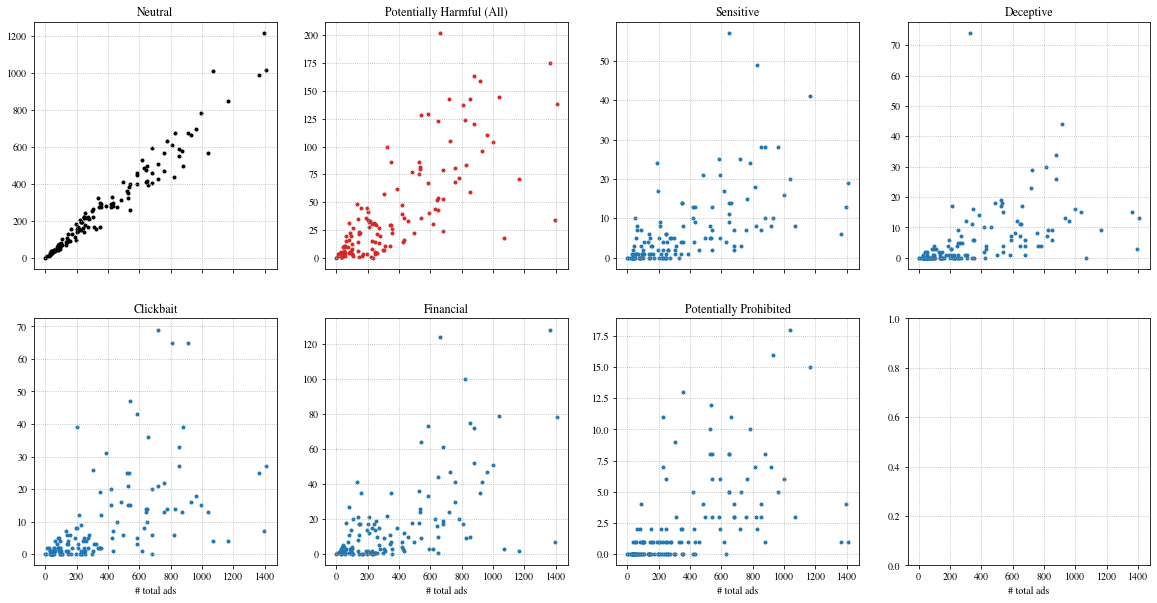

In [168]:
f, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True)

total_vals = [ann_ads_count[p] for p in active_pids]

axs[0][0].scatter(total_vals, neutral_counts, color='k', marker='.')
axs[0][0].set_title('Neutral')
print('Neutral:', pearsonr(total_vals, neutral_counts))

axs[0][1].scatter(total_vals, harmful_counts, color='tab:red', marker='.')
axs[0][1].set_title('Potentially Harmful (All)')
print('Potentially Harmful:', pearsonr(total_vals, harmful_counts))

sensitive_counts = [exposure[p]['Sensitive'] for p in active_pids]
axs[0][2].scatter(total_vals, sensitive_counts, marker='.')
axs[0][2].set_title('Sensitive')
print('Sensitive:', pearsonr(total_vals, sensitive_counts))

deceptive_counts = [exposure[p]['Potentially Harmful'] for p in active_pids]
axs[0][3].scatter(total_vals, deceptive_counts, marker='.')
axs[0][3].set_title('Deceptive')
print('Deceptive:', pearsonr(total_vals, deceptive_counts))

for i, c in enumerate(['Clickbait', 'Financial', 'Potentially Prohibited']):
    counts = [exposure[p][c] for p in active_pids]
    axs[1][i].scatter(total_vals, counts, marker='.')
    axs[1][i].set_title(c)
    
    print(f'{c}:', pearsonr(total_vals, counts))

for i in range(4):
    axs[0][i].grid(ls=':')
    axs[1][i].grid(ls=':')
    axs[1][i].set_xlabel('# total ads')

# plt.grid(ls=':')
# perhaps the x-axis should be number of ads contributed

**Thinking about distributions**: What is the random variable here? Number of ads for a type e.g. clickbait? In visualizations then, the x-axis shouldn't be the participant but the number of ads. Then the y-axis should should show p(clickbait) i.e. likelihood of a certain frequency. In this sense, neutral would be normally distributed but perhaps the others would not be.

This advice is more applicable for `individual-experiences.ipynb` perhaps.

### Individual Experiences (again): comparing fractions of total ads instead of counts

<ipython-input-22-928dec0e817f>:16: RuntimeWarning: invalid value encountered in divide
  neutral_expos_fracs = np.array(neutral_counts) / np.array(total_vals)
<ipython-input-22-928dec0e817f>:17: RuntimeWarning: invalid value encountered in divide
  harmful_expos_fracs = np.array(harmful_counts) / np.array(total_vals)
<ipython-input-22-928dec0e817f>:18: RuntimeWarning: invalid value encountered in divide
  healthcare_expos_fracs = np.array(healthcare_counts) / np.array(total_vals)
<ipython-input-22-928dec0e817f>:19: RuntimeWarning: invalid value encountered in divide
  opportunity_expos_fracs = np.array(opportunity_counts) / np.array(total_vals)
<ipython-input-22-928dec0e817f>:21: RuntimeWarning: invalid value encountered in divide
  other_expos_frac = np.array(other_counts) / np.array(total_vals)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Neutral:
 Skew: -0.111 NormaltestResult(statistic=1.928454354558654, pvalue=0.3812777460136572)
Problematic:
 Skew: 0.837 NormaltestResult(statistic=14.807720285012287, pvalue=0.0006088977865572922)
Healthcare:
 Skew: 0.847 NormaltestResult(statistic=14.946890464539987, pvalue=0.0005679681400543062)
Opportunity:
 Skew: 1.134 NormaltestResult(statistic=23.371135657888676, pvalue=8.414384897570705e-06)
Other:
 Skew: 0.834 NormaltestResult(statistic=14.694773784460114, pvalue=0.0006442737192745966)


Text(0.5, 1.0, 'Fine-grained Potentially Harmful')

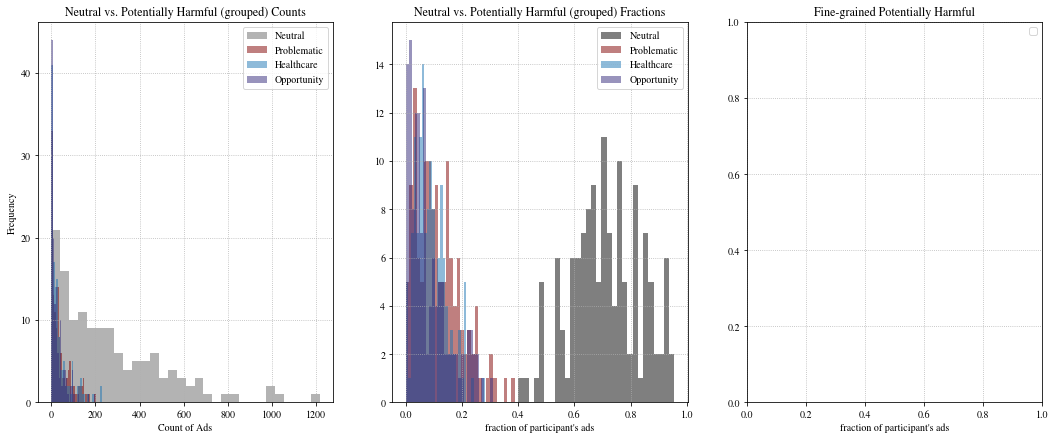

In [22]:
# since the scales are so different, let's visualize z-scores for each ad type
f, axs = plt.subplots(1, 3, figsize=(18, 7))

# pull out counts: total, neutral, problematic, healthcare and opportunity
total_vals = [ann_ads_count[p] for p in active_pids]
# `neutral_counts` and 1harmful_counts` are set from when the CDF was made
healthcare_counts = [exposure[p]['Healthcare'] for p in active_pids]
opportunity_counts = [exposure[p]['Opportunity'] for p in active_pids]

axs[0].hist(np.array(neutral_counts), bins=30, color=colors['Benign'], alpha=.5, label='Neutral')
axs[0].hist(np.array(harmful_counts), bins=30, color=colors['Problematic'], alpha=.5, label='Problematic')
axs[0].hist(np.array(healthcare_counts), bins=30, color=colors['Healthcare'], alpha=.5, label='Healthcare')
axs[0].hist(np.array(opportunity_counts), bins=30, color=colors['Opportunity'], alpha=.5, label='Opportunity')

# compute individual exposure fractions
neutral_expos_fracs = np.array(neutral_counts) / np.array(total_vals)
harmful_expos_fracs = np.array(harmful_counts) / np.array(total_vals)
healthcare_expos_fracs = np.array(healthcare_counts) / np.array(total_vals)
opportunity_expos_fracs = np.array(opportunity_counts) / np.array(total_vals)
# other_counts = [grouped_exposure[p]['other'] for p in active_pids]
other_expos_frac = np.array(other_counts) / np.array(total_vals)

axs[1].hist(neutral_expos_fracs, label='Neutral', bins=30, color='k', alpha=.5)
# axs[1].hist(other_expos_frac, label='Other', color='goldenrod', bins=30, alpha=.5)
axs[1].hist(harmful_expos_fracs, label='Problematic', bins=30, color=colors['Problematic'], alpha=.5)
axs[1].hist(healthcare_expos_fracs, label='Healthcare', bins=30, color=colors['Healthcare'], alpha=.5)
axs[1].hist(opportunity_expos_fracs, label='Opportunity', bins=30, color=colors['Opportunity'], alpha=.5)

# test neutral and harmful distributions for normality, show kurtosis and skew
print('Neutral:\n',
      'Skew:', f"{skew(neutral_expos_fracs, nan_policy='omit'):.3f}",
      # 'Kurtosis:', f"{kurtosis(neutral_expos_fracs, nan_policy='omit'):.3f}",
      # "Mode:", mode(neutral_expos_fracs),
      normaltest(neutral_expos_fracs, nan_policy='omit')
)
# "symmetric data should have a skewness near zero" (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)
print('Problematic:\n',
      'Skew:', f"{skew(harmful_expos_fracs, nan_policy='omit'):.3f}",
      # 'Kurtosis:', f"{kurtosis(harmful_expos_fracs, nan_policy='omit'):.3f}",      
      normaltest(harmful_expos_fracs, nan_policy='omit')
)

# TODO: show skew and kurtosis for opportunity and healthcare expos_frac too
print('Healthcare:\n',
      'Skew:', f"{skew(healthcare_expos_fracs, nan_policy='omit'):.3f}",
      normaltest(healthcare_expos_fracs, nan_policy='omit')
)
print('Opportunity:\n',
      'Skew:', f"{skew(opportunity_expos_fracs, nan_policy='omit'):.3f}",
      normaltest(opportunity_expos_fracs, nan_policy='omit')
)
print('Other:\n',
      'Skew:', f"{skew(other_expos_frac, nan_policy='omit'):.3f}",
      # 'Kurtosis:', f"{kurtosis(other_expos_frac, nan_policy='omit'):.3f}",
      normaltest(other_expos_frac, nan_policy='omit')
)
# p << .05 => H_0: point if from normal distribution can be rejected
"""
with the second definition (the one that scipy uses, with -3),
positive kurtosis indicates a "heavy-tailed" distribution
and negative kurtosis indicates a "light tailed" distribution.
"""

# for c in ['Sensitive', 'Potentially Harmful', 'Clickbait', 'Financial', 'Potentially Prohibited']:
#     fracs = np.array([exposure[p][c] for p in active_pids]) / np.array(total_vals)
#     axs[2].hist(fracs, label=labels[c] if c in labels else c, histtype='step', bins=30, lw=1.5)
    

for ax in axs:
    ax.legend()
    ax.grid(ls=':')
    ax.set_xlabel("fraction of participant's ads")

axs[0].set_title('Neutral vs. Potentially Harmful (grouped) Counts')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Count of Ads')
axs[1].set_title('Neutral vs. Potentially Harmful (grouped) Fractions')
axs[2].set_title('Fine-grained Potentially Harmful')

# plt.savefig('harmful_fraction_distribution.pdf', dpi=150, bbox_inches='tight')

In [129]:
# preprocess into dataframe to work with seaborn
# df_data = {'problematic': harmful_expos_fracs, 'other': other_expos_frac, 'neutral': neutral_expos_fracs}
# df_data = {'problematic': harmful_expos_fracs, 'other': other_expos_frac, 'neutral': neutral_expos_fracs}
df_data = {'problematic': harmful_expos_fracs, 'neutral': neutral_expos_fracs}
# df_data = {'problematic': harmful_expos_fracs, 'neutral': neutral_expos_fracs,
#            'healthcare': healthcare_expos_fracs, 'opportunity': opportunity_expos_fracs}
plot_df = []
for name, vals in df_data.items():
    for v in vals:
        plot_df.append([name, v])        
plot_df = pd.DataFrame(plot_df, columns=['adtype', 'fraction_diet'])

In [130]:
print('--- medians ---')
print(f'problematic: {np.nanmedian(harmful_expos_fracs):.2f}')
print(f'neutral: {np.nanmedian(neutral_expos_fracs):.2f}')
print(f'non-problematic: {np.nanmedian(other_expos_frac):.2f}')
print(f'healthcare: {np.nanmedian(healthcare_expos_fracs):.2f}')
print(f'opportunity: {np.nanmedian(opportunity_expos_fracs):.2f}')

print('\n--- means ---')
print(f'problematic: {np.nanmean(harmful_expos_fracs):.2f}')
print(f'neutral: {np.nanmean(neutral_expos_fracs):.2f}')
print(f'non-problematic: {np.nanmean(other_expos_frac):.2f}')
print(f'healthcare: {np.nanmean(healthcare_expos_fracs):.2f}')
print(f'opportunity: {np.nanmean(opportunity_expos_fracs):.2f}')

print('\n--- skewness ---')
print(f"problematic: {skew(harmful_expos_fracs, nan_policy='omit'):.3f}")
print(f"neutral: {skew(neutral_expos_fracs, nan_policy='omit'):.3f}")
print(f"non-problematic: {skew(other_expos_frac, nan_policy='omit'):.3f}")
print(f"healthcare: {skew(healthcare_expos_fracs, nan_policy='omit'):.3f}")
print(f"opportunity: {skew(opportunity_expos_fracs, nan_policy='omit'):.3f}")

print('\n--- std ---')
print(f"problematic: {np.nanstd(harmful_expos_fracs):.3f}")
print(f"neutral: {np.nanstd(neutral_expos_fracs):.3f}")
print(f"non-problematic: {np.nanstd(other_expos_frac):.3f}")
print(f"healthcare: {np.nanstd(healthcare_expos_fracs):.3f}")
print(f"opportunity: {np.nanstd(opportunity_expos_fracs):.3f}")

--- medians ---
problematic: 0.10
neutral: 0.71
non-problematic: 0.15
healthcare: 0.08
opportunity: 0.06

--- means ---
problematic: 0.12
neutral: 0.71
non-problematic: 0.17
healthcare: 0.09
opportunity: 0.08

--- skewness ---
problematic: 0.837
neutral: -0.111
non-problematic: 0.834
healthcare: 0.847
opportunity: 1.134

--- std ---
problematic: 0.081
neutral: 0.123
non-problematic: 0.093
healthcare: 0.056
opportunity: 0.072


In [155]:
plot_df

,adtype,fraction_diet
0,problematic,0.150659
1,problematic,0.114226
2,problematic,0.073034
3,problematic,0.000000
4,problematic,0.250000
...,...,...
261,neutral,0.857143
262,neutral,0.665399
263,neutral,0.697115
264,neutral,0.532051


>20% problematic in ad diet: (20, 2)


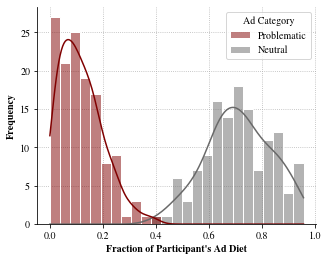

In [159]:
f, ax = plt.subplots()
# legend = ax1.get_legend()
# sns.histplot(ax=ax, data=plot_df, x="fraction_diet", kde=True, bins=25,
#              hue="adtype", edgecolor='white', fill=False, facecolor='white',
#             palette={'neutral': colors['Benign'], 'problematic': colors['Problematic'],
#                      'healthcare': colors['Healthcare'], 'opportunity': colors['Opportunity']})
sns.histplot(ax=ax, data=plot_df, x="fraction_diet", kde=True, bins=25,
             hue="adtype", edgecolor='white',
            palette={'neutral': colors['Benign'], 'problematic': colors['Problematic'],
                     'other': colors['Healthcare']})

ax.grid(ls=':')
ax.set_axisbelow(True)
ax.set_xlabel("Fraction of Participant's Ad Diet", fontweight='bold')
ax.set_ylabel("Frequency", fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = ax.get_legend()
texts = legend.get_texts()
texts[0].set_text('Problematic')
texts[1].set_text('Neutral')
legend.set_title('Ad Category')

# how many people have >20% problematic in their ad diet?
print('>20% problematic in ad diet:',
    plot_df[(plot_df['adtype'] == 'problematic') & (plot_df['fraction_diet'] >= 0.2)].shape)

f.set_size_inches(5, 4)
# f.savefig('../results/rq2_exposure.pdf', bbox_inches='tight')

In [138]:
# abstract says three times the median (median is 10%):
print(sorted(harmful_expos_fracs, reverse=True)[:10])

[0.3609022556390977, 0.3125, 0.3067484662576687, 0.30652503793626706, 0.25925925925925924, 0.25, 0.25, 0.25, 0.2379182156133829, 0.23076923076923078]


### Disambiguated Fraction of ad diets

<ipython-input-152-4f74036c55fa>:7: RuntimeWarning: invalid value encountered in divide
  df_data_fg['deceptive'] = np.array([exposure[p]['Potentially Harmful'] for p in active_pids]) / total_vals
<ipython-input-152-4f74036c55fa>:8: RuntimeWarning: invalid value encountered in divide
  df_data_fg['prohibited'] = np.array([exposure[p]['Potentially Prohibited'] for p in active_pids]) / total_vals
<ipython-input-152-4f74036c55fa>:9: RuntimeWarning: invalid value encountered in divide
  df_data_fg['clickbait'] = np.array([exposure[p]['Clickbait'] for p in active_pids]) / total_vals
<ipython-input-152-4f74036c55fa>:10: RuntimeWarning: invalid value encountered in divide
  df_data_fg['sensitive'] = np.array([exposure[p]['Sensitive'] for p in active_pids]) / total_vals
<ipython-input-152-4f74036c55fa>:11: RuntimeWarning: invalid value encountered in divide
  df_data_fg['financial'] = np.array([exposure[p]['Financial'] for p in active_pids]) / total_vals


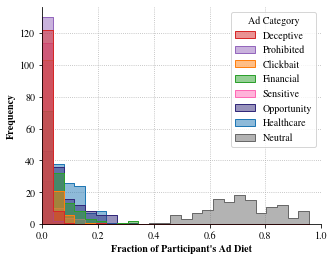

In [152]:
# finegrained DF
df_data_fg = {
    'neutral': neutral_expos_fracs,
    'healthcare': healthcare_expos_fracs,
    'opportunity': opportunity_expos_fracs    
}
df_data_fg['deceptive'] = np.array([exposure[p]['Potentially Harmful'] for p in active_pids]) / total_vals
df_data_fg['prohibited'] = np.array([exposure[p]['Potentially Prohibited'] for p in active_pids]) / total_vals
df_data_fg['clickbait'] = np.array([exposure[p]['Clickbait'] for p in active_pids]) / total_vals
df_data_fg['sensitive'] = np.array([exposure[p]['Sensitive'] for p in active_pids]) / total_vals
df_data_fg['financial'] = np.array([exposure[p]['Financial'] for p in active_pids]) / total_vals

plot_df_fg = []
for name, vals in df_data_fg.items():
    for v in vals:
        plot_df_fg.append([name, v])        
plot_df_fg = pd.DataFrame(plot_df_fg, columns=['adtype', 'fraction_diet'])
plot_df_fg = plot_df_fg.dropna()

f, ax = plt.subplots()
# ==== empty bar plot ====
# p = sns.histplot(ax=ax, data=plot_df_fg, x="fraction_diet", bins=30,
#              hue="adtype", fill=False, kde=False, alpha=1,
#             palette={'neutral': colors['Benign'], 'healthcare': colors['Healthcare'], 'opportunity': colors['Opportunity'],
#                      'deceptive': colors['Potentially Harmful'], 'prohibited': colors['Potentially Prohibited'],
#                      'clickbait': colors['Clickbait'], 'financial': colors['Financial'],
#                      'sensitive': colors['Sensitive']
#                     },
#             # least to most skewed
#             hue_order=['neutral', 'healthcare', 'opportunity', 'sensitive', 'financial', 'clickbait', 'prohibited', 'deceptive'][::-1])
# plt.setp(p.patches, linewidth=2)
# ==== filled bar plot =====
order = ['neutral', 'healthcare', 'opportunity', 'sensitive', 'financial', 'clickbait', 'prohibited', 'deceptive'][::-1]
sns.histplot(ax=ax, data=plot_df_fg, x="fraction_diet", bins=25,
             hue="adtype", fill=True, kde=False, alpha=.5, element="step",
            palette={'neutral': colors['Benign'], 'healthcare': colors['Healthcare'], 'opportunity': colors['Opportunity'],
                     'deceptive': colors['Potentially Harmful'], 'prohibited': colors['Potentially Prohibited'],
                     'clickbait': colors['Clickbait'], 'financial': colors['Financial'],
                     'sensitive': colors['Sensitive']
                    },
            # least to most skewed
            hue_order=order)
# ==== KDE plot ====
# sns.kdeplot(ax=ax, data=plot_df_fg, x="fraction_diet", bw_adjust=2, clip=(0,1), common_norm=False,
#             multiple="stack", alpha=0.7, hue="adtype", fill=True, edgecolor='white',
#             palette={'neutral': colors['Benign'], 'healthcare': colors['Healthcare'], 'opportunity': colors['Opportunity'],
#                      'deceptive': colors['Potentially Harmful'], 'prohibited': colors['Potentially Prohibited'],
#                      'clickbait': colors['Clickbait'], 'financial': colors['Financial'],
#                      'sensitive': colors['Sensitive']
#                     })

ax.grid(ls=':')
ax.set_axisbelow(True)
ax.set_xlabel("Fraction of Participant's Ad Diet", fontweight='bold')
ax.set_ylabel("Frequency", fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 1)

legend = ax.get_legend()
texts = legend.get_texts()
for i, t in enumerate(texts):
    t.set_text(order[i].title())
# texts[0].set_text('Problematic')
# texts[1].set_text('Neutral')
legend.set_title('Ad Category')

# f.set_size_inches(7, 5)
f.set_size_inches(5, 4)
f.savefig('../results/rq2_exposure_disambiguated.pdf', bbox_inches='tight')

## Stacked Bar Charts Return: Focusing on Individual Experiences

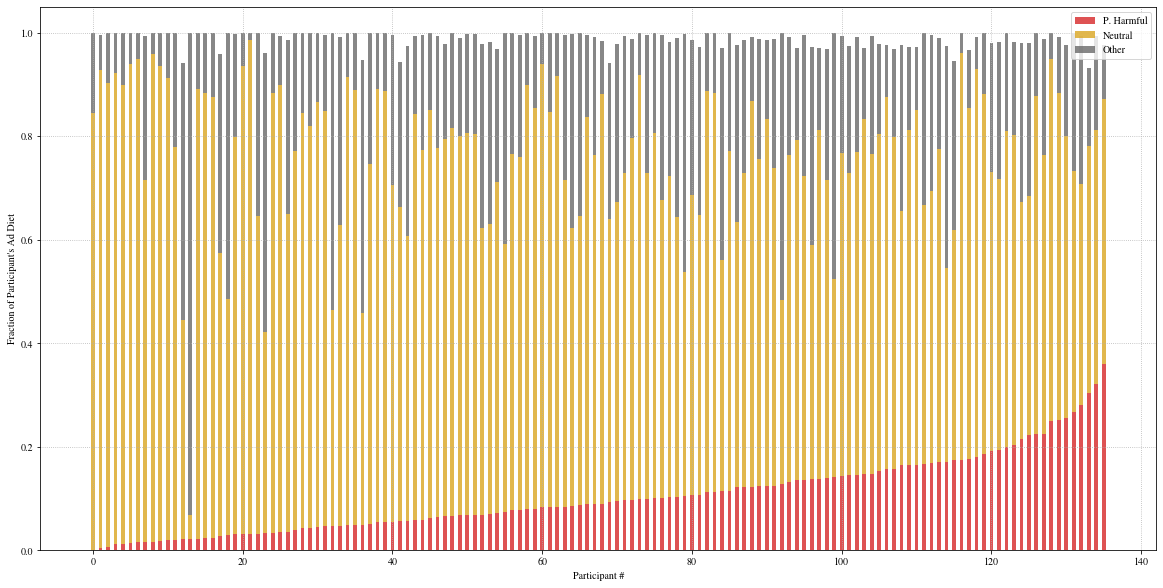

In [598]:
f, ax = plt.subplots(figsize=(20, 10))

# show plot in order of increasing fraction of harmful ads
order = [(p, grouped_exposure[p][harmful] / ann_ads_count[p]) for p in active_pids if ann_ads_count[p] > 0]
order = sorted(order, key=lambda t: t[1])
order = [t[0] for t in order]

fracs_harmful = [grouped_exposure[p]['harmful'] / ann_ads_count[p] for p in order]
fracs_neutral = [grouped_exposure[p]['non_harmful'] / ann_ads_count[p] for p in order]
fracs_other = [grouped_exposure[p]['other'] / ann_ads_count[p] for p in order]

last = np.zeros(len(order))

# Harmful
ax.bar(np.arange(len(order)), fracs_harmful, .5, label='P. Harmful', bottom=last,
    color='tab:red', alpha=.8)
last += fracs_harmful

# Neutral 
ax.bar(np.arange(len(order)), fracs_neutral, .5, label='Neutral', bottom=last,
    color='goldenrod', alpha=.8)
last += fracs_neutral

# Other
ax.bar(np.arange(len(order)), fracs_other, .5, label='Other', bottom=last,
    color='dimgray', alpha=.8)

ax.legend()
ax.grid(ls=':')
ax.set_ylabel('Fraction of Participant\'s Ad Diet')
ax.set_xlabel('Participant #')

plt.savefig('individual-diets-bar-chart.pdf', dpi=150, bbox_inches='tight')

## Narrow Down on Harm Consumers in the Top 20%

In [599]:
# who is in the top 20%?
thresh = int(0.1 * len(fracs_harmful))
top_20_consumers = order[-thresh:]
print(top_20_consumers)

['899499', '993453', '601387b4aa37e127b0544497', '606e4eb2a56685e5593304cd', '597658', '131788', '5f50732850c7c600098593df', '5f8f46ff0b55a11953d90aa5', '139835', '253977', '372771', '802434', '60a69e84d2f871b61d608e89']


In [356]:
peek = '601387b4aa37e127b0544497'
print(f"Fraction harmful: {grouped_exposure[peek]['harmful'] / ann_ads_count[peek]:.2f}")
print(exposure[peek], ann_ads_count[peek], )

Fraction harmful: 0.22
Counter({'Benign': 95, 'Opportunity': 46, 'Sensitive': 19, 'Financial': 16, 'Healthcare': 15, 'Clickbait': 9, 'Potentially Harmful': 6}) 206


In [396]:
# Inspect ads for a particular participant
pid_adid_codes[(pid_adid_codes['pid'] == peek) & ~(pid_adid_codes['codes'].str.contains('Benign'))]

,pid,adid,codes
3617,601387b4aa37e127b0544497,23849317719280477,Opportunity
3934,601387b4aa37e127b0544497,23849216639750375,Financial
4117,601387b4aa37e127b0544497,23849432017520541,Healthcare
5478,601387b4aa37e127b0544497,23849557489710545,Clickbait
8153,601387b4aa37e127b0544497,6258532232226,Healthcare
...,...,...,...
27562,601387b4aa37e127b0544497,23850101212280154,Sensitive
27565,601387b4aa37e127b0544497,23849924961240654,Opportunity
27568,601387b4aa37e127b0544497,23849545213930420,Opportunity
27569,601387b4aa37e127b0544497,6295394303723,Sensitive


### Look at Raw Counts of Harmful Ads for Top 20% Consumers

In [601]:
# what is the median exposure to clickbait, harmful ads etc. -- factoring in the frequency as well?
badcodes = ['Clickbait', 'Potentially Harmful', 'Potentially Prohibited', 'Sensitive', 'Financial']
for c in badcodes:
    print(c, np.median([exposure[p][c] for p in active_pids]))
    
# do the top 20 consumers see more of it?
print('\n=====Top 20% harmful consumers=====')
for c in badcodes:
    print(c, np.median([exposure[p][c] for p in top_20_consumers]))

Clickbait 4.0
Potentially Harmful 2.0
Potentially Prohibited 1.0
Sensitive 4.0
Financial 8.0

=====Top 20% harmful consumers=====
Clickbait 4.0
Potentially Harmful 2.0
Potentially Prohibited 0.0
Sensitive 6.0
Financial 26.0


Text(0, 0.5, 'Fraction of Ads in top 20%')

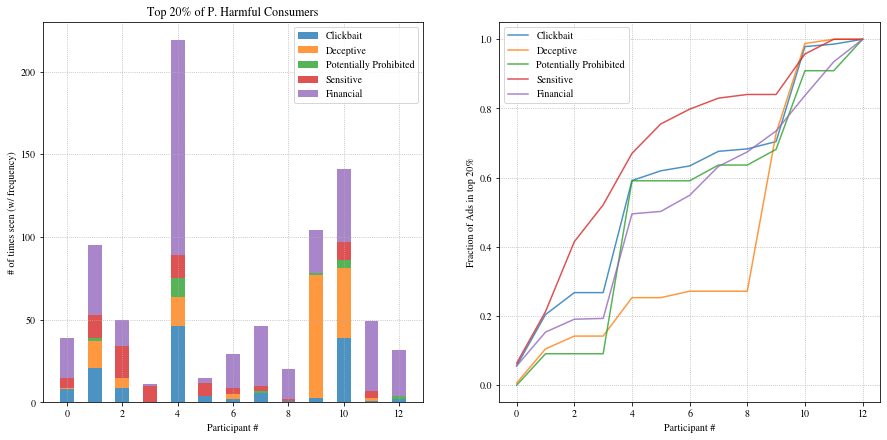

In [602]:
f, axs = plt.subplots(1, 2, figsize=(15, 7))
# show counts on axs[0], CDF on axs[1]

last = np.zeros(len(top_20_consumers))
for c in badcodes:
    counts = [exposure[p][c] for p in top_20_consumers]
    p = axs[0].bar(np.arange(len(counts)), counts, .5, label=labels[c] if c in labels else c, bottom=last, alpha=.8)
    
    last += counts
    pdf = np.array(counts) / sum(counts)
    cdf = np.cumsum(pdf)
    col = p[0].get_facecolor()
    axs[1].plot(np.arange(len(cdf)), cdf, label=labels[c] if c in labels else c, color=col)
    
for ax in axs:
    ax.legend()
    ax.grid(ls=':')
    ax.set_xlabel('Participant #')
    
axs[0].set_ylabel('# of times seen (w/ frequency)')
axs[0].set_title('Top 20% of P. Harmful Consumers')

axs[1].set_ylabel('Fraction of Ads in top 20%')

**AHA**, interesting that Deceptive focuses on the latter few. Participant 24 and 23 see a lot more deceptive than the rest!
Participant 9 here seens a lot more sensitive. Financial seems common throughout, prohibited are few and far between.
Clickbait focuses a little more on the few in the beginning.

But also, looking at some of these small bars -- I think perhaps I should double-check if people in the top here are also people who had the highest _number_ of harmful ads, and not just the fractions.

**Writing Idea:** One way of writing this in the paper is to have a table with deceptive, clickbait, prohibited etc as columns and each participants' exact numbers explicitly shown. Top/bottom row could describe median number of ads in that category for the panel overall for comparision. A Table is a much better way to both identify these participants and then talk in detail about their experiences by mentioning participant number.

In [391]:
# This person saw the free laptops ads -- they're in our top 20% as well
# pid_adid[pid_adid['adid'] == 23849682981140535]

# buy coins -- they are also in the top 20% (participant 23 in above plot)
pid_adid[pid_adid['adid'] == 23849629319480598]

,pid,adid
31373,253977,23849629319480598


In [391]:
# This person saw the free laptops ads -- they're in our top 20% as well
# pid_adid[pid_adid['adid'] == 23849682981140535]

# buy coins -- they are also in the top 20% (participant 23 in above plot)
pid_adid[pid_adid['adid'] == 23849629319480598]

,pid,adid
31373,253977,23849629319480598


In [429]:
# drop rows with 'None' in adid
pid_adid_freqs_noind = pid_adid_freqs_noind[pid_adid_freqs_noind.adid.str.isnumeric()]
# convert adid column to integer
pid_adid_freqs_noind['adid'] = pid_adid_freqs_noind.adid.astype('int64')

pid_adid_freqs_codes = pid_adid_freqs_noind.merge(codes, how='inner', on='adid')

#### Move over to demographic differences:
export DF of number of ads out of total, merge with `ALLDEMS_EXP.csv` later

In [260]:
# TODO: modify this export to include counts for all

export = []
for p in active_pids:
    # row format: pid, total, (counts for) harmful, non_harmful, sensitive, deceptive, clickbait, financial, potentially prohibited
    row = [p]
    row.append(ann_ads_count[p])
    row.append(grouped_exposure[p][harmful])
    row.append(grouped_exposure[p][non_harmful])
    row.append(grouped_exposure[p]['other'])
    # raw opportunity and healthcare counts
    row.append(exposure[p]['Opportunity'])
    row.append(exposure[p]['Healthcare'])
    for c in ['Sensitive', 'Potentially Harmful', 'Clickbait', 'Financial', 'Potentially Prohibited']:
        row.append(exposure[p][c])
        
    export.append(row)
        
export_df = pd.DataFrame(export, columns=['pid', 'total', 'harmful_grouped', 'neutral', 'other', 'opportunity', 'healthcare', 'sensitive',
                                          'deceptive', 'clickbait', 'financial', 'prohibited'])
export_df.to_csv(os.path.join(DATA_DIR, 'harmful_counts_df.csv'), index=False)